## Download code

In [1]:
%%capture
!git clone https://github.com/AI4EPS/EQNet
!python -m pip install -r EQNet/requirements.txt

## Download event data

More test examples: https://huggingface.co/datasets/AI4EPS/quakeflow_das

In [1]:
import os
import torch
import numpy as np
import h5py
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

Text(0, 0.5, 'Time (s)')

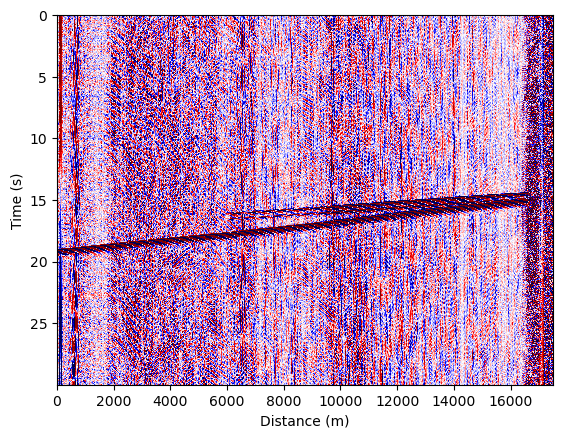

In [14]:
normalize = lambda x: (x - np.mean(x, axis=-1, keepdims=True)) / np.std(x, axis=-1, keepdims=True)
# h5_files = glob("data/*.h5")
# for file in h5_files:
file = f"data/DAS_20250423122330_20250423122400.h5"
with h5py.File(file, "r") as fp:
    data = fp["Acquisition/Raw[0]/RawData"][()]
    dt = 1/ fp["Acquisition/Raw[0]"].attrs["OutputDataRate"]

    dx = fp["Acquisition"].attrs["SpatialSamplingInterval"]
    nx, nt = data.shape
    x = np.arange(nx) * dx
    t = np.arange(nt) * dt
        
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")


## Run PhaseNet-DAS

In [ ]:
ngpu = torch.cuda.device_count()
base_cmd = "/home/disk/disk01/wzm/EQNet/predict.py --model phasenet_das --data_list=files.txt  --data_path ./data --result_path ./results --format=h5  --batch_size 1 --workers 0"

In [15]:
with open("files.txt", "w") as f:
    f.write(f"data/{event_id}.h5")

if ngpu == 0:
    cmd = f"python {base_cmd} --device cpu"
elif ngpu == 1:
    cmd = f"python {base_cmd}"
else:
    cmd = f"torchrun --nproc_per_node {ngpu} {base_cmd}"

print(cmd)
os.system(cmd)

python /home/disk/disk01/wzm/EQNet/predict.py --model phasenet_das --data_list=files.txt  --data_path / --result_path ./results --format=h5  --batch_size 1 --workers 0


/home/wuzm/anaconda3/envs/base_archive/lib/python3.11/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Not using distributed mode
Namespace(model='phasenet_das', resume='', backbone='unet', phases=['P', 'S'], device='cuda', workers=0, batch_size=1, use_deterministic_algorithms=False, amp=False, world_size=1, dist_url='env://', data_path='/', data_list='files.txt', hdf5_file=None, prefix='', format='h5', dataset='das', result_path='./results', plot_figure=False, min_prob=0.3, add_polarity=False, add_event=False, sampling_rate=100.0, highpass_filter=0.0, response_path=None, response_xml=None, subdir_level=0, cut_patch=False, nt=20480, nx=5120, resample_time=False, resample_space=False, system=None, location=None, skip_existing=False, distributed=False)
Total samples: 1 files


Predicting: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


0

## Plot results

In [11]:
event_id = "DAS_20250423122330_20250423122400"
picks = pd.read_csv(f"results/picks_phasenet_das/{event_id}.csv")

Text(0, 0.5, 'Time (s)')

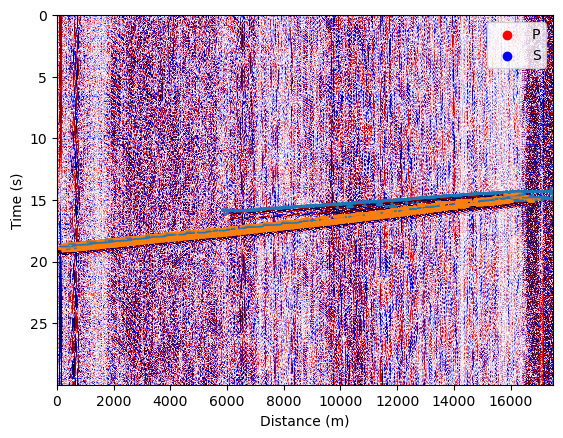

In [12]:
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
color = picks["phase_type"].map({"P": "C0", "S": "C1"})
plt.scatter(picks["channel_index"].values * dx, picks["phase_index"].values * dt, c=color, s=1)
plt.scatter([], [], c="r", label="P")
plt.scatter([], [], c="b", label="S")
plt.legend()
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")

## Support for OptaSense hdf5 format

In [9]:
filename = "2022-06-18T11:22:49.660Z/Eureka-DT1087-2m-P5kHz-fs250Hz_2022-06-18T112221Z.h5"
if not os.path.exists(f'data/Eureka-DT1087-2m-P5kHz-fs250Hz_2022-06-18T112221Z.h5'):
    os.system(f"wget https://huggingface.co/datasets/AI4EPS/quakeflow_das/resolve/main/data/eureka/2022-06-18T11:22:49.660Z/Eureka-DT1087-2m-P5kHz-fs250Hz_2022-06-18T112221Z.h5 -P data > log.txt 2>&1")

Text(0, 0.5, 'Time (s)')

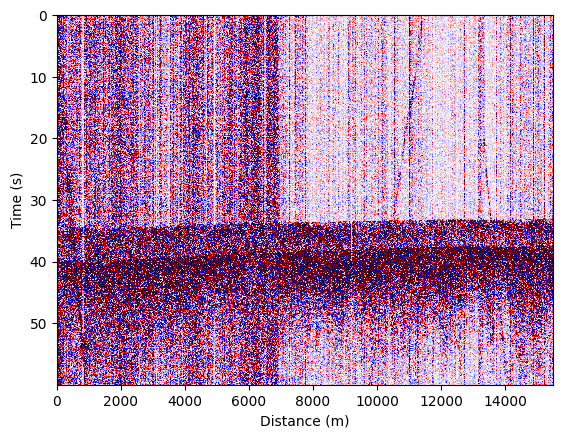

In [10]:
normalize = lambda x: (x - np.mean(x, axis=-1, keepdims=True)) / np.std(x, axis=-1, keepdims=True)
with h5py.File(f"data/{filename.split('/')[-1]}", "r") as fp:

    dx = fp["Acquisition"].attrs["SpatialSamplingInterval"]
    fs = fp['Acquisition/Raw[0]'].attrs["OutputDataRate"]
    dt = 1.0 / fs
    data = fp["Acquisition/Raw[0]/RawData"][...]
    data = np.gradient(data, axis=-1) / dt

    nx, nt = data.shape
    x = np.arange(nx) * dx
    t = np.arange(nt) * dt
        
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")

In [11]:
with open("files.txt", "w") as f:
    f.write(f"data/{filename.split('/')[-1]}")

if ngpu == 0:
    cmd = f"python {base_cmd} --device cpu --system optasense"
elif ngpu == 1:
    cmd = f"python {base_cmd} --system optasense"
else:
    cmd = f"torchrun --nproc_per_node {ngpu} {base_cmd} --system optasense"

print(cmd)
os.system(cmd)

python EQNet/predict.py --model phasenet_das --data_list=files.txt  --data_path ./data --result_path ./results --format=h5  --batch_size 1 --workers 0 --device cpu --system optasense
Not using distributed mode
Namespace(model='phasenet_das', resume='', backbone='unet', phases=['P', 'S'], device='cpu', workers=0, batch_size=1, use_deterministic_algorithms=False, amp=False, world_size=1, dist_url='env://', data_path='./data', data_list='files.txt', hdf5_file=None, prefix='', format='h5', dataset='das', result_path='./results', plot_figure=False, min_prob=0.3, add_polarity=False, add_event=False, highpass_filter=0.0, response_path=None, response_xml=None, folder_depth=0, cut_patch=False, nt=20480, nx=5120, resample_time=False, resample_space=False, system='optasense', location=None, skip_existing=False, distributed=False)
Total samples: 1 files


Predicting: 100%|██████████| 1/1 [01:17<00:00, 77.69s/it]


0

In [12]:
picks = pd.read_csv(f"results/picks_phasenet_das/{filename.split('/')[-1].split('.')[0]}.csv")

Text(0, 0.5, 'Time (s)')

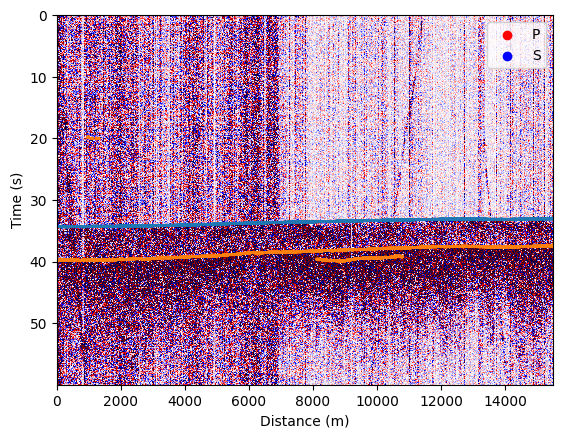

In [13]:
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
color = picks["phase_type"].map({"P": "C0", "S": "C1"})
plt.scatter(picks["channel_index"].values * dx, picks["phase_index"].values * dt, c=color, s=1)
plt.scatter([], [], c="r", label="P")
plt.scatter([], [], c="b", label="S")
plt.legend()
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")

**Notes:**

- The model was trained on data with a channel spacing of 8-10 m, and a sampling rate of 100 Hz. The model will have a reduced performance on data with different channel spacing and sampling rate.